In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10

In [2]:
from keras.utils import to_categorical  # Correct import for to_categorical

In [3]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()

In [4]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


In [5]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

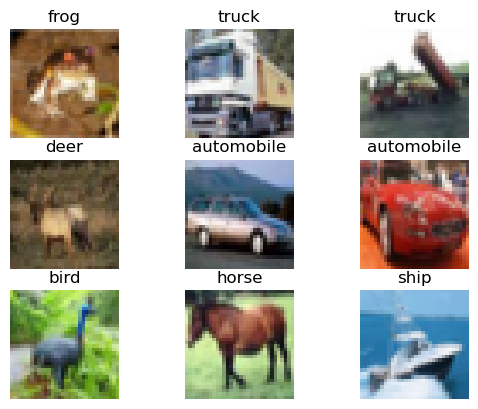

In [6]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    #plt.xlabel(classes[y_train[i]])
    plt.title(classes[y_train[i][0]])
    plt.axis('off')
    #print(classes[y_train[i]])
plt.show()

## Normalize and Re-shape the data

In [7]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0, 255, 0, 255)

In [8]:
X_train = X_train.astype('float16')
X_test = X_test.astype('float16')
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

In [10]:
x_train = X_train.reshape(-1,3072)
x_test = X_test.reshape(-1,3072)
#y_train = y_train.reshape(-1,)
#y_test = y_test.reshape(-1,)

In [11]:
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [12]:
y_train
a = to_categorical(y_test)
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

## Create Dataframe

In [13]:
x_train.shape,x_test.shape

((50000, 3072), (10000, 3072))

In [14]:
#flatten images
#x_train_flat = X_train.reshape(-1,3072)
col_name = ['pixel' + str(i) for i in range(x_train.shape[1])]
df = pd.DataFrame(x_train, columns = col_name)
df['Label'] = y_train
print('Size of Data Frame: {}'.format(df.shape))

Size of Data Frame: (50000, 3073)


In [15]:
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,Label
0,0.231323,0.243164,0.247070,0.168579,0.180420,0.176514,0.196045,0.188232,0.168579,0.266602,...,0.847168,0.721680,0.548828,0.592285,0.462646,0.329346,0.482422,0.360840,0.282471,6
1,0.604004,0.694336,0.733398,0.494141,0.537109,0.533203,0.411865,0.407959,0.372559,0.399902,...,0.560547,0.521484,0.544922,0.560547,0.525391,0.556641,0.560547,0.521484,0.564941,9
2,1.000000,1.000000,1.000000,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.305908,0.333252,0.325439,0.309814,0.333252,0.325439,0.313721,0.337158,0.329346,9
3,0.109802,0.098022,0.039215,0.145142,0.133301,0.074524,0.149048,0.137207,0.078430,0.164673,...,0.211792,0.184326,0.109802,0.247070,0.219604,0.145142,0.282471,0.254883,0.180420,4
4,0.666504,0.706055,0.776367,0.658691,0.698242,0.768555,0.694336,0.725586,0.795898,0.717773,...,0.294189,0.309814,0.321533,0.278320,0.294189,0.305908,0.286377,0.302002,0.313721,1


## Logistic Regression on origional dataset

In [16]:
def LR(x_train, y_train, x_test, y_test, solver):
    y_train = y_train.reshape(-1,)
    y_test = y_test.reshape(-1,)
    model_logreg = LogisticRegression(solver = solver,multi_class='multinomial')
    model_logreg.fit(x_train, y_train)
    y_pred = model_logreg.predict(x_test)
    y_pred_prob =  model_logreg.predict_proba(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    num_params = sum(len(coef) for coef in model_logreg.coef_) + model_logreg.intercept_.shape[0]
    return accuracy, num_params

In [17]:
output_LR = LR(x_train, y_train, x_test, y_test, solver='sag')
print(output_LR)

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(0.3963, 30730)


## Artificial Neural Network on origional dataset

In [18]:
def NN(x_train, y_train, x_test, y_test, optimizer,epochs):
    model_NN = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(3072,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Compile model
    model_NN.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
    
    #model_NN.fit(x_train_pca, y_train, epochs=epochs, )
    history = model_NN.fit(x_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping], validation_data=(x_test, y_test))
    
    #Test data performance
    loss, accuracy = model_NN.evaluate(x_test, y_test)
    num_params = model_NN.count_params()
    
    return accuracy, num_params

In [19]:
optimizer= ['adam','SGD']
output_NN = []
for optimizer in optimizer:
    result = NN(x_train, y_train, x_test, y_test, optimizer, epochs=50)
    output_NN = output_NN + [optimizer, result]
print(output_NN)

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2688 - loss: 1.9952 - val_accuracy: 0.3803 - val_loss: 1.7104
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3868 - loss: 1.7128 - val_accuracy: 0.4019 - val_loss: 1.6528
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4140 - loss: 1.6299 - val_accuracy: 0.4329 - val_loss: 1.5709
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4372 - loss: 1.5701 - val_accuracy: 0.4155 - val_loss: 1.6533
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4513 - loss: 1.5322 - val_accuracy: 0.4363 - val_loss: 1.5655
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4622 - loss: 1.5050 - val_accuracy: 0.4578 - val_loss: 1.5089
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4689 - loss: 1.4755 - val_accuracy: 0.4573 - val_loss: 1.5074
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4785 - loss: 1.4627 - 

## PCA Application & Logistic Regression

In [34]:
# default solver is incredibly slow which is why it was changed to 'lbfgs'
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
def PCA_LR(n_components, x_train, y_train, x_test, y_test, solver):
    pca = PCA(n_components = n_components)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    y_train = y_train.reshape(-1,)
    y_test = y_test.reshape(-1,)
    
    model_logreg = LogisticRegression(solver = solver, multi_class='multinomial')
    model_logreg.fit(x_train_pca, y_train)
    y_pred = model_logreg.predict(x_test_pca)
    y_pred_prob =  model_logreg.predict_proba(x_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    num_params = sum(len(coef) for coef in model_logreg.coef_) + model_logreg.intercept_.shape[0]
    return accuracy, num_params


In [35]:
features = [658,217,99]
#accuracy_PCA_LR = []
output_PCA_LR = []
solver = 'sag'
for i in features:
    result = PCA_LR(i, x_train, y_train, x_test, y_test, solver)
    output_PCA_LR = output_PCA_LR + [i,result]
print(output_PCA_LR)

[658, (0.4045, 6590), 217, (0.4073, 2180), 99, (0.401, 1000)]


## NN Application with PCA : Fusion-Net

In [37]:
def Fusion_Net(n_components, x_train, y_train, x_test, y_test, optimizer,epochs):
    #1 PCA
    pca = PCA(n_components = n_components)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    #2 NN model with Two hidden layers and output layer
    model_NN = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(n_components,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Compile model
    model_NN.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
    
    #add batch gradinet descent 
    history = model_NN.fit(x_train_pca, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping],validation_data=(x_test_pca, y_test) )

    #Test data performance
    loss, accuracy = model_NN.evaluate(x_test_pca, y_test)
    num_params = model_NN.count_params()
    
    return accuracy, num_params

In [38]:
features = [658,217,99]
#accuracy_FusNet = []
output_FusNet = []
optimizer = ['adam','SGD']
epochs = 50
for i in features:
    for n in optimizer:
        result = Fusion_Net(i, x_train, y_train, x_test, y_test, n,epochs)
        output_FusNet = output_FusNet + [i,n,result]
        #print(i,',',n,':',result)
print(output_FusNet)

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3739 - loss: 1.7596 - val_accuracy: 0.4960 - val_loss: 1.4343
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5408 - loss: 1.2996 - val_accuracy: 0.5123 - val_loss: 1.3756
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6103 - loss: 1.1117 - val_accuracy: 0.5235 - val_loss: 1.3681
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6598 - loss: 0.9619 - val_accuracy: 0.5223 - val_loss: 1.4059
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6986 - loss: 0.8463 - val_accuracy: 0.5124 - val_loss: 1.4673
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7450 - loss: 0.7313 - val_accuracy: 0.5021 - val_loss: 1.5751
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7741 - loss: 0.6449 - val_accuracy: 0.4985 - val_loss: 1.6948
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8016 - loss: 0.5664 -

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2794 - loss: 2.0134 - val_accuracy: 0.4030 - val_loss: 1.6870
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4167 - loss: 1.6536 - val_accuracy: 0.4369 - val_loss: 1.5779
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4549 - loss: 1.5455 - val_accuracy: 0.4624 - val_loss: 1.5157
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4863 - loss: 1.4591 - val_accuracy: 0.4743 - val_loss: 1.4701
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5013 - loss: 1.4079 - val_accuracy: 0.4853 - val_loss: 1.4425
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5173 - loss: 1.3671 - val_accuracy: 0.4860 - val_loss: 1.4434
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5372 - loss: 1.3109 - val_accuracy: 0.4930 - val_loss: 1.4229
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5498 - loss: 1.2808 - 

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3654 - loss: 1.7826 - val_accuracy: 0.4834 - val_loss: 1.4451
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5187 - loss: 1.3596 - val_accuracy: 0.5125 - val_loss: 1.3774
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5681 - loss: 1.2267 - val_accuracy: 0.5166 - val_loss: 1.3562
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6023 - loss: 1.1246 - val_accuracy: 0.5299 - val_loss: 1.3445
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6294 - loss: 1.0423 - val_accuracy: 0.5287 - val_loss: 1.3570
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6587 - loss: 0.9707 - val_accuracy: 0.5273 - val_loss: 1.3708
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6734 - loss: 0.9158 - val_accuracy: 0.5252 - val_loss: 1.4093
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6947 - loss: 0.8529 - val_accurac

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2495 - loss: 2.0532 - val_accuracy: 0.3922 - val_loss: 1.7194
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4048 - loss: 1.6807 - val_accuracy: 0.4280 - val_loss: 1.6138
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4413 - loss: 1.5804 - val_accuracy: 0.4456 - val_loss: 1.5488
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4668 - loss: 1.5090 - val_accuracy: 0.4645 - val_loss: 1.5109
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4867 - loss: 1.4506 - val_accuracy: 0.4793 - val_loss: 1.4680
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5046 - loss: 1.3997 - val_accuracy: 0.4861 - val_loss: 1.4514
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5184 - loss: 1.3627 - val_accuracy: 0.4749 - val_loss: 1.4586
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5278 - loss: 1.3367 - val_accurac

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3577 - loss: 1.7980 - val_accuracy: 0.4782 - val_loss: 1.4758
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4987 - loss: 1.4136 - val_accuracy: 0.5068 - val_loss: 1.3779
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5408 - loss: 1.2895 - val_accuracy: 0.5207 - val_loss: 1.3484
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5752 - loss: 1.2007 - val_accuracy: 0.5252 - val_loss: 1.3409
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5985 - loss: 1.1336 - val_accuracy: 0.5315 - val_loss: 1.3325
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6136 - loss: 1.0882 - val_accuracy: 0.5282 - val_loss: 1.3434
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6290 - loss: 1.0440 - val_accuracy: 0.5219 - val_loss: 1.3658
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6412 - loss: 1.0035 - val_accurac

C:\Users\ThokozileKhosa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2719 - loss: 2.0274 - val_accuracy: 0.3923 - val_loss: 1.7144
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4051 - loss: 1.6905 - val_accuracy: 0.4295 - val_loss: 1.6073
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4399 - loss: 1.5885 - val_accuracy: 0.4523 - val_loss: 1.5448
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4634 - loss: 1.5220 - val_accuracy: 0.4632 - val_loss: 1.5066
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4780 - loss: 1.4755 - val_accuracy: 0.4746 - val_loss: 1.4708
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4996 - loss: 1.4183 - val_accuracy: 0.4789 - val_loss: 1.4516
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5074 - loss: 1.3949 - val_accuracy: 0.4864 - val_loss: 1.4304
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5194 - loss: 1.3678 - val_accurac

## Model Parameters & Results

In [39]:
print(output_LR)
print(output_NN)
print(output_PCA_LR)
print(output_FusNet)

(0.3963, 30730)
['adam', (0.46619999408721924, 418762), 'SGD', (0.4674000144004822, 418762)]
[658, (0.4045, 6590), 217, (0.4073, 2180), 99, (0.401, 1000)]
[658, 'adam', (0.5235000252723694, 109770), 658, 'SGD', (0.513700008392334, 109770), 217, 'adam', (0.5299000144004822, 53322), 217, 'SGD', (0.5141000151634216, 53322), 99, 'adam', (0.531499981880188, 38218), 99, 'SGD', (0.5238000154495239, 38218)]
